This notebook compares `DopplerCIB` with `galCIB` and checks for any issues. `DopplerCIB` is well-tested and `galCIB` is a derivative of the codebase. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# galCIB modules

import consts
import powerspectra as ps
import halo
import gal 
import precalc as pc
import cib
import cosmology

(210,)
Note: redshifts have been re-sorted (earliest first)


/Users/tkarim/research/galCIB/powerspectra.py:63: RuntimeWarning: divide by zero encountered in log10
  ELL_sampled = np.logspace(np.log10(consts.LMIN),
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


In [4]:
# DopplerCIB modules

import sys 
sys.path.append("//Users/tkarim/research/DopplerCIB/")

import CIB_halo as mcib
import cosmo_related as mcosmo
import input_var_cibmean as minput
import Gal_halo as mgh
import CIBxGal_halo as mcg
import hmf_unfw_bias as mhmf_unfw

First initialize relevant `DopplerCIB` objects

In [5]:
## initialize cosmo_var_iv and data_var_iv to pass to DopplerCIB

cosmo_var = mcosmo.cosmo_var_iv(mass=consts.Mh_Msol,
                                z=consts.Plin['z'],
                                do_powerspec=1)

# experimental specification 

cib_exp = 'Planck'
# color corrections for 100, 143, 217, 353, 545, 857 and 3000 GHz for Planck
cc_pl = np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995])  # , 0.960])
cc = cc_pl  

nu0 = np.array([100., 143., 217., 353., 545., 857.]) 
nus = ['100', '143', '217', '353', '545', '857']
# fwhm obtained from https://wiki.cosmos.esa.int/planckpla/index.php/Effective_Beams
fwhm = np.array([9.651, 7.248, 4.990, 4.818, 4.682, 4.325])  # in arcmin
fwhm_rad = fwhm*(np.pi/180.)/60.
# fwhm = 4.8  # 4.8 Planck arcmin # 0.5 CCAT-Prime
# 1303.5067 for sensitivity (Tab:4 muK deg & kJy/sr deg)
sensitivity_muKarcmin = np.array([108., 48., 60., 210., 1137., 29075.])
sensitivity_Jy2_sr = np.array([58., 26.929, 72., 305, 369., 369.])
sensitivity_Jy_sr = np.sqrt(sensitivity_Jy2_sr)
# sensitivity = 13.5  # 13.5 Planck Jy/sr  # 1.2 CCAT-Prime
ell = np.logspace(2, np.log10(2000), 99)
fc = np.ones(len(nu0))

strfig = "allcomponents_lognormal_sigevol_1p5zcutoff_nolens_onlyautoshotpar_no3000_gaussian600n857n1200_planck_spire_hmflog10.txt"
cibres = "/Users/tkarim/research/galCIB/data/one_halo_bestfit_"+strfig

exp = {'name': cib_exp,
          'do_cibmean': 0,
          'cc': cc,
          'fc': fc,
          'snuaddr': '/Users/tkarim/research/galCIB/data/filtered_snu_planck.fits',
          # 'nu0min': nu0min, 'nu0max': nu0max,
          # 'nucen': str(int(nucen)),
          'nu0': nu0,
          'ell': ell,
          'fwhm': fwhm,
          'sensitivity': sensitivity_Jy_sr,
          'cibpar_resfile': cibres,
          'nu_string': nus}

## initialize data_var_iv 
data_var_iv = minput.data_var_iv(exp = exp)

## initialize CIBXGal_halo.py
# mcibgal_obj_pk = mcg.CIBxgal(data_var_iv=data_var_iv,
#                           cosmo_var_iv=cosmo_var,
#                           gal_exp='DESI_ELG',
#                           r_l=1)

Calculating the halo mass function for given mass and redshift for CIB mean calculations.
[39.52037275]
5.298428495800479e-17
2.4832862197860225e-18


In [6]:
# output of DopplerCIB
gal_obj_m21 = mgh.ProfHODMore15(data_var_iv, cosmo_var, gal_exp='DESI_ELG')

In [85]:
# define fiducial values for M21 model

# 1- to 2- halo smoothing transition parameter is set to 1; but Mead++20 finds this to be 0.7 at z~0
hmalphas = np.ones(10) 

# shotnoise defined over log10 for sampling efficiency; 
# define as log10(N_shot/Jy/sr) = theta_shot;
# use unWISE green best-fit value because it is closest to ELG p(z)
shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = shotnoise_gCIB - 2 # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.log10(np.array([225, 543, 913, 1454, 2655, 5628]))
shotnoise_all = np.concatenate((shotnoise_gCIB, shotnoise_CIBCIB))

# physical parameters of importance
gal_params = np.array([gal_obj_m21.gamma, gal_obj_m21.log10mc, gal_obj_m21.sLog10m, gal_obj_m21.Ac, # Ncen (4): gamma, log10Mc, sigmaM, Ac
                       gal_obj_m21.As, np.log10(gal_obj_m21.m0), gal_obj_m21.m1, gal_obj_m21.alpha_]) # Nsat (4): As, M0, M1, alpha
prof_params = np.array([0., 6.14, 1]) # fexp, tau, lambda_NFW
cib_params = np.array([0.49, 11.52, -0.02, 2.74, 0.5, 2.15, 11.38, 0.4]) # SFR (6): etamax, mu_peak0, mu_peakp, sigma_M0, tau, zc, Mmin_IR, IR_sigma_lnM

all_params = np.concatenate((hmalphas, shotnoise_all, gal_params, prof_params, cib_params))

In [86]:
c_all_k25 = ps.c_all(theta=all_params, cib_model='M21')

you set meanIR to 1 by hand for testing.


We will test all the three power spectra and each component that makes them up. 

# Component 1: Galaxy-Galaxy $C_{\rm gg}$

From now on, we will tag the outputs of this package as K25, and DopplerCIB as M21. 

We compare the following: 
- galterm
- $P_{\rm 2h} (k)$
- $P_{\rm 1h} (k)$
- $C_{\rm 2h} (\ell)$
- $C_{\rm 1h} (\ell)$
- $C_{\rm tot} (\ell)$
    

## Fourier of NFW Profile

In [10]:
# call unfw from DopperCIB
unfw_m21 = gal_obj_m21.unfw # function of ell and z

In [11]:
unfw_m21 = np.swapaxes(unfw_m21, 0,1) # same axis as the other code

unfw_k25 = halo.nfwfourier_u(lambda_NFW=1, rad200=pc.rad200, 
                             c=pc.concentration, 
                             c_term=pc.concentration_amp)  

In [9]:
ratio = unfw_k25/unfw_m21
ratio.shape # (k, mass, z); z ranges from idx 5 to 16 covering 0.55 to 1.65; 
#mass ranges from idx 55 to 75 covering 11.44 to 13.06

ValueError: operands could not be broadcast together with shapes (199,100,102) (99,100,102) 

In [10]:
# look for which index results in the most deviation 
np.where(ratio.max() == ratio)

NameError: name 'ratio' is not defined

In [11]:
# corresponding mass value
print(consts.log10Mh[99])
print(consts.Plin['z'][0])

15.0
0.05


In [12]:
# plot of the worst agreement 
plt.loglog(ell, ratio[:,99,0])

NameError: name 'ratio' is not defined

This could be due to a number of issues. One of the best tests is to compare explicitly what `DopplerCIB` returns for unfw. 

### Components of `fourier_u`

In [12]:
from astropy.cosmology import Planck18 as planck

#### `r_delta == 200`

In [13]:
hub_obj_m21 = mhmf_unfw.h_u_b(kk=consts.Plin['k'],
                  power=consts.Plin['pk'],
                  z=consts.Plin['z'][0],
                  cosmo=planck,
                  delta_h=200,
                  mh=consts.Mh_Msol)

In [14]:
hub_obj_m21.r_delta()/pc.rad200[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
# test for all redshifts

for zidx in range(len(consts.Plin['z'])):
    hub_obj_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol)
    
    ratio = hub_obj_m21.r_delta()/pc.rad200[:,zidx]
    is_one = ratio.sum()/len(ratio)
    
    assert is_one == 1.0, "Ratio is incorrect" # answer should match exactly

Therefore, `r_delta == 200` matches as long as the mass passed to NFW is $M_h$ fully and NOT $M_{h_c}$

#### `dlnpk_dlnk`

In [16]:
zidx = 0
hub_obj_m21 = mhmf_unfw.h_u_b(kk=consts.Plin['k'],
                  power=consts.Plin['pk'][zidx],
                  z=consts.Plin['z'][zidx],
                  cosmo=planck,
                  delta_h=200,
                  mh=consts.Mh_Msol)

In [17]:
pc.dlnpk_dlnk[:,zidx]/hub_obj_m21.dlnpk_dlnk()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
# test for all redshifts

for zidx in range(len(consts.Plin['z'])):
    hub_obj_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol)
    
    ratio = pc.dlnpk_dlnk[:,zidx]/hub_obj_m21.dlnpk_dlnk()
    is_one = ratio.sum()/len(ratio)
    
    assert is_one == 1.0, "Ratio is incorrect" # answer should match exactly

We had issue with the `mass_to_radius` definition so had to fix this. Now `k_R` matches. 

We also had issue with passing the wrong $P(k)$ and $k$ to `dlnpk_dlnk`; we passed the smaller range over which $\ell$ is evaluated rather than the large $P_{\rm mm} (k)$. This would lead to a wrong derivative calculation. 

In [19]:
zidx = 0
hub_obj_m21 = mhmf_unfw.h_u_b(kk=consts.Plin['k'],
                  power=consts.Plin['pk'][zidx],
                  z=consts.Plin['z'][zidx],
                  cosmo=planck,
                  delta_h=200,
                  mh=consts.Mh_Msol)

In [20]:
pc.concentration[:,zidx]/hub_obj_m21.nu_to_c200c()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
# test for all redshifts

for zidx in range(len(consts.Plin['z'])):
    hub_obj_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol)
    
    ratio = pc.concentration[:,zidx]/hub_obj_m21.nu_to_c200c()
    is_one = ratio.sum()/len(ratio)
    
    assert is_one == 1.0, "Ratio is incorrect" # answer should match exactly

#### `r_star`

In [22]:
zidx = 0
hub_obj_m21 = mhmf_unfw.h_u_b(kk=consts.Plin['k'],
                  power=consts.Plin['pk'][zidx],
                  z=consts.Plin['z'][zidx],
                  cosmo=planck,
                  delta_h=200,
                  mh=consts.Mh_Msol)

In [23]:
r_s_k25 = halo.r_star(pc.rad200, pc.concentration)
r_s_m21 = hub_obj_m21.r_star()

In [24]:
r_s_k25[:,zidx]/r_s_m21

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
# test for all redshifts

r_s_k25 = halo.r_star(pc.rad200, pc.concentration)

for zidx in range(len(consts.Plin['z'])):
    hub_obj_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol)
    
    
    r_s_m21 = hub_obj_m21.r_star()
    ratio = r_s_k25[:,zidx]/r_s_m21
    is_one = ratio.sum()/len(ratio)
    
    assert is_one == 1.0, "Ratio is incorrect" # answer should match exactly

#### `ampl_nfw`

In [26]:
amp_nfw_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol)

In [28]:
pc.concentration_amp[:,zidx]/amp_nfw_m21

TypeError: unsupported operand type(s) for /: 'float' and 'h_u_b'

In [27]:
# test for all redshifts

for zidx in range(len(consts.Plin['z'])):
    hub_obj_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol)
    
    c = hub_obj_m21.nu_to_c200c() # concentration
    amp_nfw_m21 = hub_obj_m21.ampl_nfw(c)

    ratio = pc.concentration_amp[:,zidx]/amp_nfw_m21
    is_one = ratio.sum()/len(ratio)
    
    assert is_one == 1.0, "Ratio is incorrect" # answer should match exactly

#### `nfwfourier_u`

In [73]:
zidx = 61
hub_obj_m21 = mhmf_unfw.h_u_b(kk=consts.Plin['k'],
                  power=consts.Plin['pk'][zidx],
                  z=consts.Plin['z'][zidx],
                  cosmo=planck,
                  delta_h=200,
                  mh=consts.Mh_Msol)

In [78]:
unfw_m21 = hub_obj_m21.nfwfourier_u()[0]

In [75]:
unfw_k25 = halo.nfwfourier_u(lambda_NFW=1,
                  rad200=pc.rad200,
                  c=pc.concentration,
                  c_term=pc.concentration_amp)
unfw_k25.shape

(199, 100, 102)

In [76]:
unfw_k25_interp = np.interp(hub_obj_m21.kk, 
                                    consts.k_grid_over_ell[:,zidx],
                                    unfw_k25[:,96,zidx])

In [80]:
ratio = unfw_k25_interp/unfw_m21

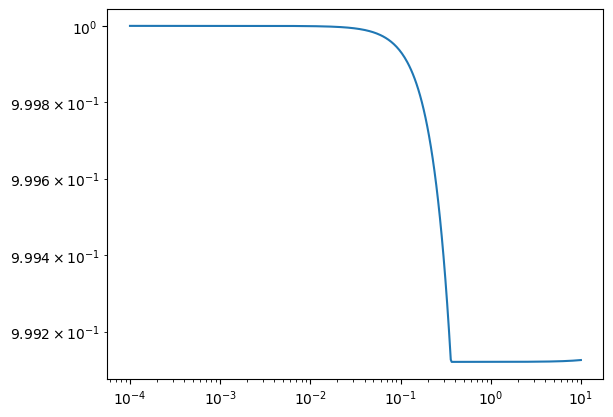

In [81]:
plt.loglog(consts.Plin['k'],
           ratio)

In [88]:
np.sum(np.abs(ratio - 1) * 100 > 0.5)

0

In [129]:
# test for all redshifts and mass range

for zidx in range(len(consts.Plin['z'])):
    for midx in range(len(consts.Mh_Msol)):
        hub_obj_m21 = mhmf_unfw.h_u_b(kk = consts.Plin['k'],
                   power = consts.Plin['pk'][zidx],
                   z = consts.Plin['z'][zidx],
                   cosmo = planck,
                   delta_h = 200,
                   mh = consts.Mh_Msol[midx])
    
        unfw_m21 = hub_obj_m21.nfwfourier_u()[0]
        
        unfw_k25_interp = np.interp(hub_obj_m21.kk, 
                                    consts.k_grid_over_ell[:,zidx],
                                    unfw_k25[:,midx,zidx])
    
    
        ratio = 100*np.abs(unfw_k25_interp/unfw_m21 - 1)
        
        kflag = (consts.Plin['k'] < 0.65) # only consider up to kmax = 0.65
        
        if (ratio[kflag] > 0.5).sum() > 0:
            print(zidx, midx, 
                  ratio[kflag].max(),
                  consts.Plin['k'][np.where(ratio[kflag].max() == ratio[kflag])])
        
        #is_one = ratio.sum()/ratio.size
    
        #assert is_one == 1.0, "Ratio is incorrect" # answer should match exactly

23 99 0.5176628983746712 [0.64211857]
24 99 0.5358797231320933 [0.64211857]
25 99 0.5475478937958522 [0.64211857]
26 99 0.5540656831300117 [0.64211857]
27 99 0.5565359395876657 [0.64211857]
28 99 0.5558219167187683 [0.64211857]
29 99 0.5526173371113607 [0.64211857]
30 99 0.5474696424492942 [0.64211857]
31 99 0.5408170290088998 [0.64211857]
32 99 0.5330131389310822 [0.64211857]
33 99 0.5243381772072286 [0.64211857]
34 99 0.5150199495373098 [0.64211857]
35 99 0.5052407702168749 [0.64211857]


In [130]:
consts.log10Mh[99]

15.0

`unfw` matches up to $k_{\rm max} = 0.65$. Some divergence starts appearing for $\log M_h = 15.0$ at smaller scales beyond that.  

#### `interp_nfw`

In [37]:
karray_m21 = cosmo_var.karray(consts.ell, consts.Plin['z'])
karray_k25 = consts.k_grid_over_ell

In [38]:
ratio = karray_k25/karray_m21

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_81785/200156141.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = karray_k25/karray_m21


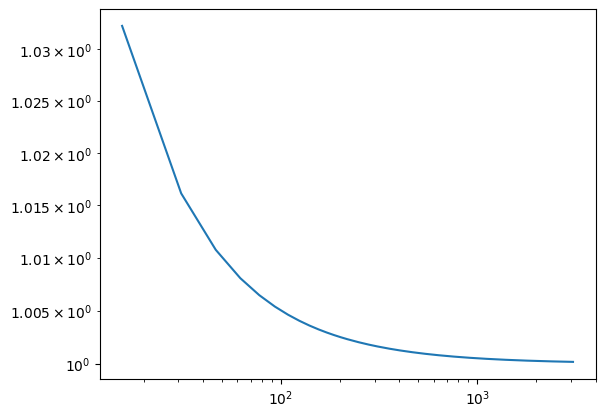

In [39]:
zidx = 10
plt.loglog(consts.ell,
           ratio[:,zidx])

This difference comes up due to the $k = \frac{\ell + 0.5}{\chi (z)}$ correction. 

In [131]:
# output of DopplerCIB
gal_obj_m21 = mgh.ProfHODMore15(data_var_iv, cosmo_var, gal_exp='DESI_ELG')

nfw_ureds shape = (100, 500, 102)
self.nfw_u = (100, 500, 210)


In [132]:
unfw_final_m21 = gal_obj_m21.unfw
unfw_final_m21.shape

(100, 99, 102)

In [133]:
unfw_k25 = halo.nfwfourier_u(lambda_NFW=1,
                  rad200=pc.rad200,
                  c=pc.concentration,
                  c_term=pc.concentration_amp)
unfw_k25.shape

(199, 100, 102)

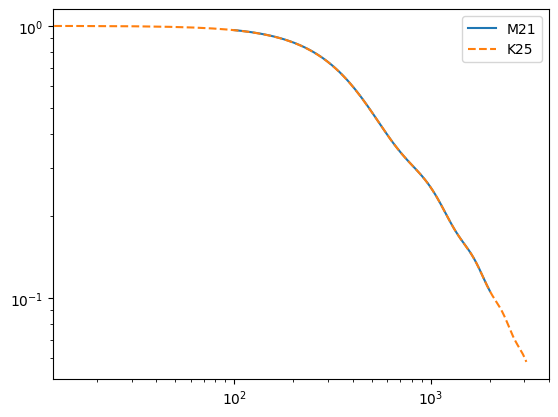

In [137]:
midx=99
zidx=0

plt.loglog(data_var_iv.ell, unfw_final_m21[midx,:,zidx],
           label = 'M21')
plt.loglog(consts.ell, unfw_k25[:,midx,zidx],
           ls = '--', label='K25')
plt.legend(loc='best')

Issue was that I sampled $\ell$ over a different grid than `DopplerCIB`. 

Test this with interpolation and with a $0.5\%$ tolerance. 

In [138]:
for midx in range(len(consts.Mh_Msol)):
    for zidx in range(len(consts.Plin['z'])):
        unfw_k25_interp = np.interp(data_var_iv.ell, 
                        consts.ell, 
                        unfw_k25[:,midx,zidx])
        
        threshold = np.sum((unfw_final_m21[midx,:,zidx]/unfw_k25_interp - 1)*100 > 0.5)
        
        if threshold:
            print(f'midx = {midx}, zidx = {zidx}')

Therefore there is a full agreement between the NFW profiles. 

## $C_{gg}$

In [8]:
# output of DopplerCIB
gal_obj_m21 = mgh.ProfHODMore15(data_var_iv, 
                                cosmo_var, 
                                gal_exp='DESI_ELG')

nfw_ureds shape = (100, 500, 102)
self.nfw_u = (100, 500, 210)


In [9]:
cgg_m21 = gal_obj_m21.cl_galtot()

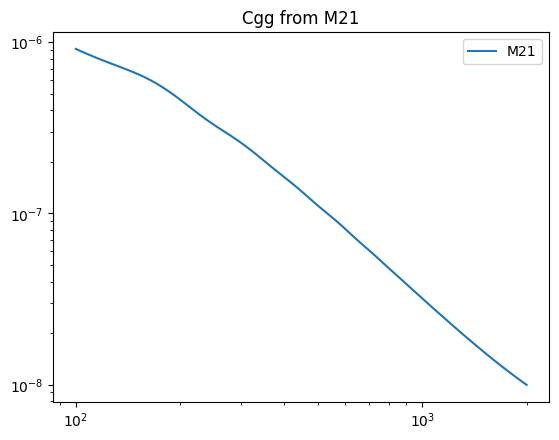

In [10]:
plt.loglog(data_var_iv.ell, cgg_m21,
           label='M21')
plt.title("Cgg from M21")
plt.legend(loc='best')

In [11]:
# define fiducial values for M21 model

# 1- to 2- halo smoothing transition parameter is set to 1; but Mead++20 finds this to be 0.7 at z~0
hmalphas = np.ones(10) 

# shotnoise defined over log10 for sampling efficiency; 
# define as log10(N_shot/Jy/sr) = theta_shot;
# use unWISE green best-fit value because it is closest to ELG p(z)
shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = shotnoise_gCIB - 2 # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.log10(np.array([225, 543, 913, 1454, 2655, 5628]))
shotnoise_all = np.concatenate((shotnoise_gCIB, shotnoise_CIBCIB))

# physical parameters of importance
gal_params = np.array([gal_obj_m21.gamma, gal_obj_m21.log10mc, gal_obj_m21.sLog10m, gal_obj_m21.Ac, # Ncen (4): gamma, log10Mc, sigmaM, Ac
                       gal_obj_m21.As, np.log10(gal_obj_m21.m0), gal_obj_m21.m1, gal_obj_m21.alpha_]) # Nsat (4): As, M0, M1, alpha
prof_params = np.array([0., 6.14, 1]) # fexp, tau, lambda_NFW
cib_params = np.array([0.49, 11.52, -0.02, 2.74, 0.5, 2.15, 11.38, 0.4]) # SFR (6): etamax, mu_peak0, mu_peakp, sigma_M0, tau, zc, Mmin_IR, IR_sigma_lnM

all_params = np.concatenate((hmalphas, shotnoise_all, gal_params, prof_params, cib_params))

In [12]:
c_all_k25 = ps.c_all(theta=all_params, cib_model='M21')

Text(0.5, 1.0, 'Comparison of Cgg')

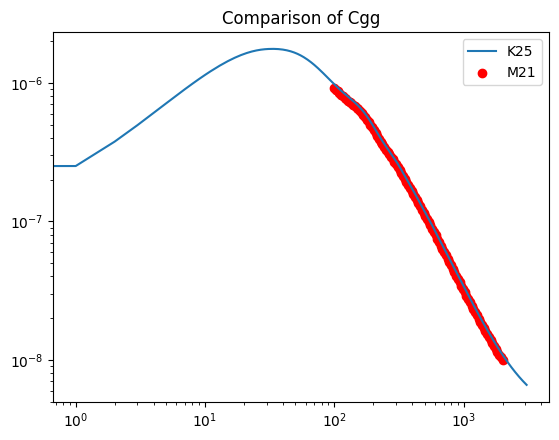

In [13]:
plt.loglog(ps.ell_range, c_all_k25[0], label = 'K25')
plt.scatter(data_var_iv.ell, cgg_m21,
           label='M21', marker="o",
           c='red')
plt.legend(loc='best')
plt.title("Comparison of Cgg")

In [14]:
# interpolate galCIB to DopplerCIB grid 
cgg_k25_interp = np.interp(data_var_iv.ell, ps.ell_range, c_all_k25[0])

Text(0.5, 1.0, 'Comparison of K25 and M21 over Cgg')

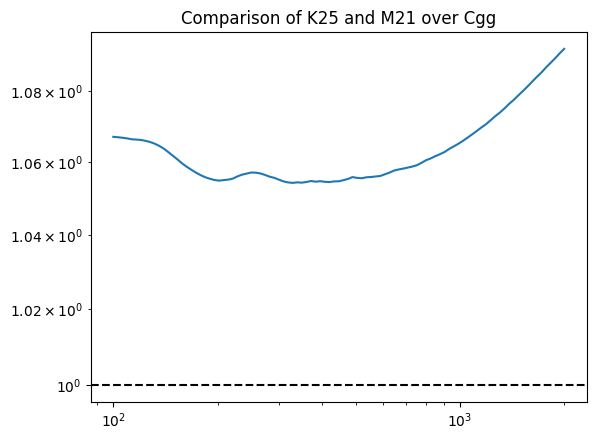

In [15]:
plt.loglog(data_var_iv.ell, cgg_k25_interp/cgg_m21)
plt.axhline(1, c = 'k', ls = '--')
plt.title("Comparison of K25 and M21 over Cgg")

Therefore, the discrepancy is at the level of $6 - 8\%$

## galterm

This represents $N_c + N_s \times u$

In [16]:
## output of galCIB

# not invoking the exponential behavior of ELGs; purely NFW
uprof_k25 = halo.nfwfourier_u(lambda_NFW=1, rad200=pc.rad200, 
                              c=pc.concentration, c_term=pc.concentration_amp)  

params_gal = np.array([gal_obj_m21.gamma, gal_obj_m21.log10mc, 
                       gal_obj_m21.sLog10m, gal_obj_m21.Ac, # Ncen (4): gamma, log10Mc, sigmaM, Ac
                       gal_obj_m21.As, np.log10(gal_obj_m21.m0), 
                       gal_obj_m21.m1, gal_obj_m21.alpha_]) # Nsat (4): As, M0, M1, alpha

galterm_k25, ncen_k25, nsat_k25 = gal.galterm(params=params_gal,
                          u=uprof_k25,
                          gal_type='ELG')
nbar_halo_k25 = gal.nbargal_halo(ncen_k25, nsat_k25, ps.hmfzT)

#### `Ncen` and `Nsat`

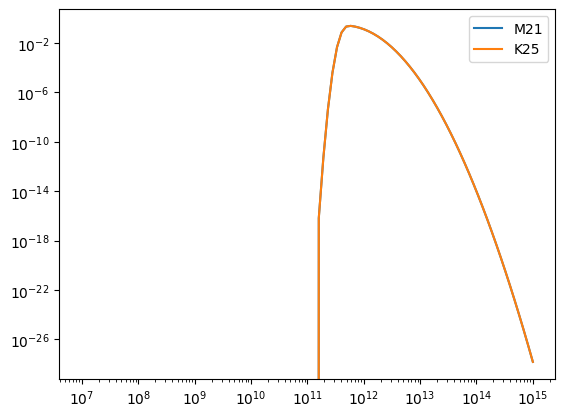

In [17]:
plt.loglog(consts.Mh_Msol,
           gal_obj_m21.Ncen(consts.Mh_Msol),label='M21')
plt.loglog(consts.Mh_Msol,
           ncen_k25,label='K25')
plt.legend(loc='best')

In [18]:
ncen_k25/gal_obj_m21.Ncen(consts.Mh_Msol)

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_10900/1904564410.py:1: RuntimeWarning: invalid value encountered in divide
  ncen_k25/gal_obj_m21.Ncen(consts.Mh_Msol)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [19]:
for midx in range(len(consts.Mh_Msol)):
    ns_m21 = gal_obj_m21.Nsat(consts.Mh_Msol[midx])    
    ratio = nsat_k25[midx]/ns_m21
    
    if np.isnan(ratio):
        print(f'nan = {midx}')
    elif ratio != 1.0:
        print(f'not 1.0, {midx}')

nan = 0
nan = 1
nan = 2
nan = 3
nan = 4
nan = 5
nan = 6
nan = 7
nan = 8
nan = 9
nan = 10
nan = 11
nan = 12
nan = 13
nan = 14
nan = 15
nan = 16
nan = 17
nan = 18
nan = 19
nan = 20
nan = 21
nan = 22
nan = 23
nan = 24
nan = 25
nan = 26
nan = 27
nan = 28
nan = 29
nan = 30
nan = 31
nan = 32
nan = 33
nan = 34
nan = 35
nan = 36
nan = 37
nan = 38
nan = 39
nan = 40
nan = 41
nan = 42
nan = 43
nan = 44
nan = 45
nan = 46
nan = 47
nan = 48
nan = 49
nan = 50
nan = 51


/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_10900/4257680694.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ratio = nsat_k25[midx]/ns_m21


Entered conformity bias factor in a wrong way. I was passing $\log_{10} (M_0)$ while comparing with $M_h$

In [23]:
unfw_final_m21 = gal_obj_m21.unfw # unfw from M21
unfw_k25 = halo.nfwfourier_u(lambda_NFW=1,
                  rad200=pc.rad200,
                  c=pc.concentration,
                  c_term=pc.concentration_amp) # unfw from K25

In [24]:
for midx in range(len(consts.Mh_Msol)):
    for zidx in range(len(consts.Plin['z'])):
        
        ncen_m21 = gal_obj_m21.Ncen(consts.Mh_Msol[midx])
        nsat_m21 = gal_obj_m21.Nsat(consts.Mh_Msol[midx])
        galterm_m21 = ncen_m21+nsat_m21*unfw_final_m21[midx,:,zidx]
        
        unfw_k25_interp = np.interp(data_var_iv.ell, 
                        consts.ell, 
                        unfw_k25[:,midx,zidx])
        
        galterm_k25_mz = ncen_k25[midx] + nsat_k25[midx]*unfw_k25_interp
        
        threshold = np.sum((galterm_k25_mz/galterm_m21 - 1)*100 > 0.5)
        
        if threshold:
            print(f'midx = {midx}, zidx = {zidx}')

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_10900/3126226833.py:14: RuntimeWarning: invalid value encountered in divide
  threshold = np.sum((galterm_k25_mz/galterm_m21 - 1)*100 > 0.5)


Therefore, `galterm` matches within threshold. 

#### HMF * halo bias

In [25]:
np.sum((gal_obj_m21.hmfmz * gal_obj_m21.biasmz)/ps.hmfzTXbias)/ps.hmfzTXbias.size

1.0

Therefore, halo bias * HMF matches exactly.

#### 2-halo terms 

In [26]:
gal_obj_m21.nbargal()/nbar_halo_k25

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]])

In [27]:
pk2h_k25 = ps.galcrossgal_pk_2h(galterm_k25, 
                     nbar_halo_k25)[0]

In [28]:
# now we want to check if the matter power spectra grid in K25 is the same as M21
power_m21 = gal_obj_m21.uni.Pk_array(consts.ell,
                         consts.Plin['z'])
ratio = power_m21/ps.Pk_lin[0]
ratio

array([[0.0552344 , 0.14065868, 0.22163381, ..., 1.00004218, 1.0000885 ,
        1.00009822],
       [1.07320221, 1.03084555, 1.01141534, ..., 0.97331705, 0.97336315,
        0.97336653],
       [1.00721294, 1.01536311, 1.01526864, ..., 0.9888486 , 0.98888286,
        0.98887508],
       ...,
       [1.00001335, 1.00167221, 1.00104047, ..., 1.00036587, 1.00038586,
        1.00040189],
       [1.00001335, 1.00206038, 1.00133772, ..., 1.00036925, 1.00038884,
        1.00039187],
       [1.00001335, 1.00198838, 1.0011634 , ..., 1.00037271, 1.00039188,
        1.00039479]])

This suggests that the $k$ grid that `DopplerCIB` is using is different from `galCIB`

Now we interpolate K25 exactly on M21 for proper comparison. 

In [29]:
nl = len(consts.ell)
print(nl)
nz = len(consts.Plin['z'])
print(nz)
zpk = np.loadtxt('/Users/tkarim/research/DopplerCIB/data_files/redshifts.txt')
nreds = len(zpk)
print(nreds)

199
102
210


In [30]:
# sampling over desired ells in the CIB redshift frame
pk1 = np.zeros((nl,nreds)) 

# convert ells to k space 
k1 = np.zeros_like(pk1)

# sampling over desired ells in the cross-corr frame
Pk_int = np.zeros((nl,nz))

# k in cross-corr frame
k_int = np.zeros_like(Pk_int)

In [31]:
from astropy.cosmology import Planck18 as planck

In [32]:
# interpolate k over specific values to match ells 

for i in range(nreds):
    #ell_chi = (data_var_iv.ell+0.5)/planck.comoving_distance(zpk[i]).value
    
    # we replace k grid with galCIB for comparison
    ell_chi = (consts.ell+0.5)/planck.comoving_distance(zpk[i]).value
    
    # note cosmo_var.k and consts.Plin['k'] are same 
    pk1[:,i] = np.interp(ell_chi, 
                         cosmo_var.k, 
                         cosmo_var.Pk[:,i])
    
    k1[:,i] = ell_chi

In [33]:
for i in range(nl):
    Pk_int[i,:] = np.interp(consts.Plin['z'],
                             zpk, pk1[i,:])
    
    k_int[i,:] = np.interp(consts.Plin['z'],
                             zpk, k1[i,:])

In [34]:
np.sum(np.abs(consts.k_grid_over_ell/k_int - 1) * 100 > 0.5)

# first bin is the discrepant one over 0.5%

199

Calculate what the k-grid is for the $P(k)$

In [36]:
p2h_m21 = gal_obj_m21.p2h_gal(np.ones_like(np.swapaxes(unfw_k25,0,1)),
                              np.swapaxes(unfw_k25,0,1),
                              Pk_int)

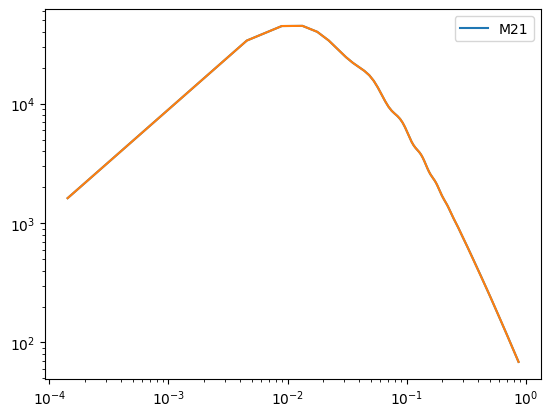

In [37]:
zidx = 10
plt.loglog(k_int[:,zidx], p2h_m21[:,zidx],label='M21')
plt.loglog(consts.k_grid_over_ell[:,zidx],
           pk2h_k25[:,zidx])
plt.legend(loc='best')


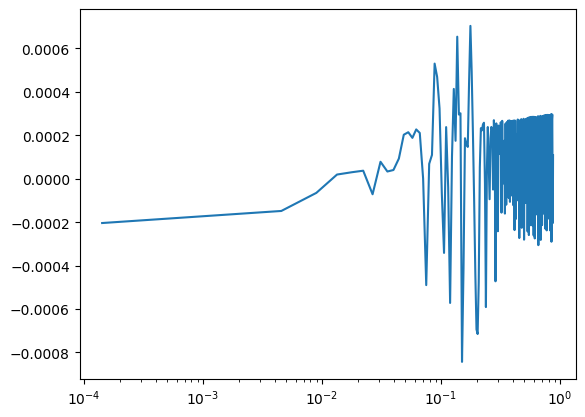

In [38]:
zidx = 10
plt.semilogx(k_int[:,zidx], 
           pk2h_k25[:,zidx]/p2h_m21[:,zidx] - 1)


In [39]:
for zidx in range(len(consts.Plin['z'])):
    ratio = 100*np.abs(pk2h_k25[:,zidx]/p2h_m21[:,zidx] - 1)
    
    if np.any(ratio > 0.5):
        print(zidx)

0


Therefore, the 2-halo term of $P(k)$ matches.

### Angular Power Spectrum

Since $P(k)$ matches, now we check for the angular power spectrum.

#### 2-halo term

In [143]:
# from M21 
cl2h_m21_from_DCIB = gal_obj_m21.cl2h_gal()

In [42]:
# check k25 using the original prefactor but also
# not taking mag bias into consideration 
# since M21 does not take mag bias into account 
# at theory level.

from scipy.integrate import simpson

# angular power including mag bias
cl2h_k25 = simpson(pk2h_k25 * ps.prefact_gg,
                   x=ps.z_all, axis=-1)

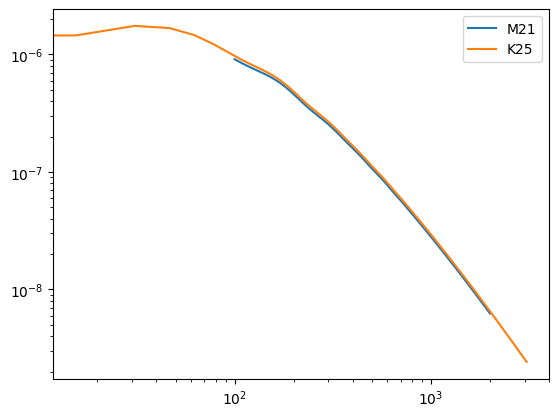

In [144]:
plt.loglog(gal_obj_m21.ell, cl2h_m21_from_DCIB,
           label = 'M21')
plt.loglog(consts.ell, cl2h_k25,
           label = 'K25')
plt.legend(loc='best')

There is some noticeable discrepancy between the two curves.

In [65]:
prefact_gg_no_mbias = ((pc.w_gal/consts.dchi_dz)**2) * (consts.dchi_dz/consts.chi2)
prefact_gg_no_mbias = prefact_gg_no_mbias.value

In [54]:
# now consider without mag bias. 

# angular power including mag bias
cl2h_k25_no_mag_bias = simpson(pk2h_k25 * prefact_gg_no_mbias,
                               x=ps.z_all, axis=-1)

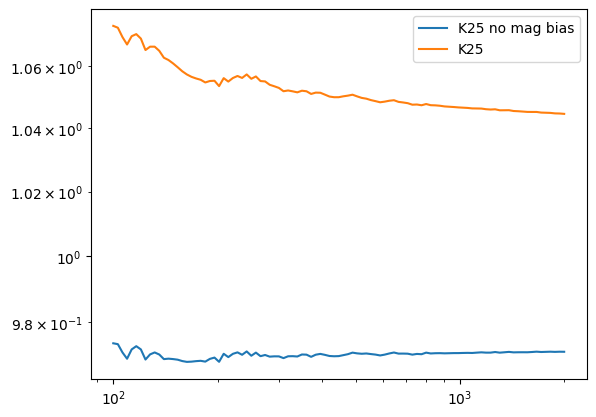

In [64]:
plt.loglog(gal_obj_m21.ell, 
           np.interp(gal_obj_m21.ell, consts.ell, cl2h_k25_no_mag_bias)/cl2h_m21,
           label = 'K25 no mag bias')

plt.loglog(gal_obj_m21.ell, 
           np.interp(gal_obj_m21.ell, consts.ell, cl2h_k25)/cl2h_m21,
           label = 'K25')

plt.legend(loc='best')

Now this discrepancy could arise because M21 uses a different power spectrum. So we will use the exact same p2h_m21 used in the previous test.

In [136]:
# calculate window using M21 functions 

dchidz_m21 = cosmo_var.dchi_dz(consts.Plin['z'])

window_m21_func = gal_obj_m21.window_gal()
wind_gal_m21 = window_m21_func(consts.Plin['z'])/dchidz_m21

# using K25 function
wind_gal_k25 = (pc.w_gal/consts.dchi_dz).value

In [137]:
ratio = wind_gal_k25/wind_gal_m21
ratio

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_10900/2104206848.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = wind_gal_k25/wind_gal_m21


array([0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521,
       0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521,
       0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521,
       0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521,
       0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521, 0.9856521,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 

This difference of $1.5\%$ comes from the fact that `DopplerCIB` normalizes $p(z)$ to $1$ exactly wheread in `galCIB` we have not. 

In [138]:
# calculate cl2h using pk2h_m21 

geo_m21 = dchidz_m21 * wind_gal_m21**2/cosmo_var.chi(consts.Plin['z'])**2

cl2h_m21_same_grid = simpson(geo_m21 * p2h_m21, 
                             x=consts.Plin['z'],
                             axis=-1)

In [139]:
ratio = np.abs(cl2h_k25_no_mag_bias/cl2h_m21_same_grid-1)*100

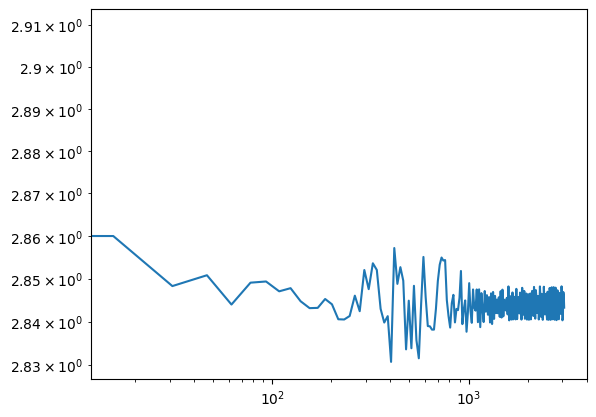

In [140]:
plt.loglog(consts.ell, ratio)

In [141]:
ratio

array([2.90971969, 2.8600006 , 2.848287  , 2.85081921, 2.8439769 ,
       2.84908374, 2.84935995, 2.8470598 , 2.84779687, 2.84474365,
       2.84313945, 2.84319887, 2.84526898, 2.84402902, 2.84054589,
       2.84048991, 2.84130541, 2.84604716, 2.84242078, 2.85203719,
       2.84756633, 2.85361572, 2.85204997, 2.84297348, 2.83978232,
       2.84127029, 2.83063566, 2.85718921, 2.84880564, 2.85271281,
       2.8495322 , 2.83354339, 2.8448785 , 2.83380427, 2.84835018,
       2.83572434, 2.83146967, 2.84421213, 2.85509997, 2.84576752,
       2.83895999, 2.83890207, 2.8381353 , 2.83813427, 2.84296536,
       2.84948452, 2.85328838, 2.85496434, 2.85425662, 2.85437482,
       2.84500765, 2.84130067, 2.8386057 , 2.84429719, 2.84624023,
       2.83981426, 2.84296216, 2.84268175, 2.84551954, 2.85181623,
       2.83941348, 2.84287911, 2.84493746, 2.83764236, 2.84210714,
       2.84897233, 2.84249388, 2.83971537, 2.84749779, 2.84320343,
       2.8425535 , 2.84749559, 2.8398675 , 2.84752391, 2.83871

This difference of $3\%$ is most likely due to the $p(z)$ calibration. We will check this by explicitly setting the $p(z)$ in K25 to match M21. 

In [124]:
# prefactor normalized pz integral to 1 
w_gal_k25_pz_norm = pc.w_gal/pc.w_gal.sum()/0.1 #delta z = 0.1

prefact_gg_no_mbias_pz_norm = ((w_gal_k25_pz_norm/consts.dchi_dz)**2) * (consts.dchi_dz/consts.chi2)
prefact_gg_no_mbias_pz_norm = prefact_gg_no_mbias_pz_norm.value

In [125]:
# now consider without mag bias. 

# angular power including mag bias
cl2h_k25_no_mag_bias_pz_norm = simpson(pk2h_k25 * prefact_gg_no_mbias_pz_norm,
                               x=ps.z_all, axis=-1)

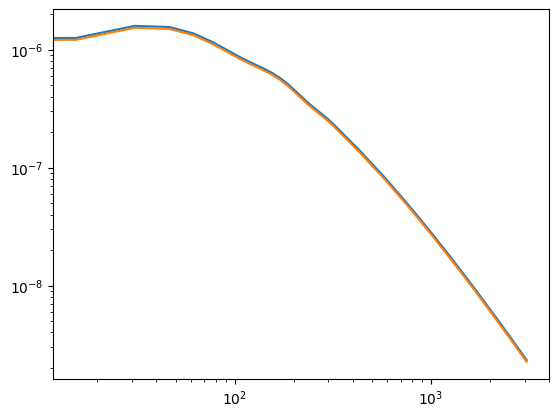

In [133]:
plt.loglog(consts.ell, cl2h_k25_no_mag_bias_pz_norm)
plt.loglog(consts.ell, cl2h_k25_no_mag_bias)

In [134]:
ratio = np.abs(cl2h_k25_no_mag_bias_pz_norm/cl2h_m21_same_grid-1)*100
ratio

array([0.71281955, 0.76439371, 0.77654436, 0.77391767, 0.78101527,
       0.77571789, 0.77543137, 0.77781734, 0.77705277, 0.78021991,
       0.78188397, 0.78182233, 0.77967498, 0.78096121, 0.78457429,
       0.78463236, 0.78378643, 0.77886776, 0.78262945, 0.77265424,
       0.77729192, 0.77101681, 0.77264099, 0.78205613, 0.78536635,
       0.78382287, 0.79485428, 0.76731   , 0.77600637, 0.77195341,
       0.77525269, 0.79183807, 0.78008003, 0.79156745, 0.77647882,
       0.78957574, 0.79398916, 0.78077127, 0.76947719, 0.77915784,
       0.78621937, 0.78627945, 0.78707483, 0.7870759 , 0.78206455,
       0.77530216, 0.77135637, 0.76961787, 0.770352  , 0.77022939,
       0.77994607, 0.78379135, 0.78658688, 0.78068303, 0.77866749,
       0.78533323, 0.78206788, 0.78235875, 0.77941507, 0.77288345,
       0.78574895, 0.78215402, 0.78001887, 0.78758616, 0.7829548 ,
       0.77583345, 0.78255363, 0.7854358 , 0.77736301, 0.7818176 ,
       0.78249178, 0.77736529, 0.785278  , 0.77733592, 0.78647

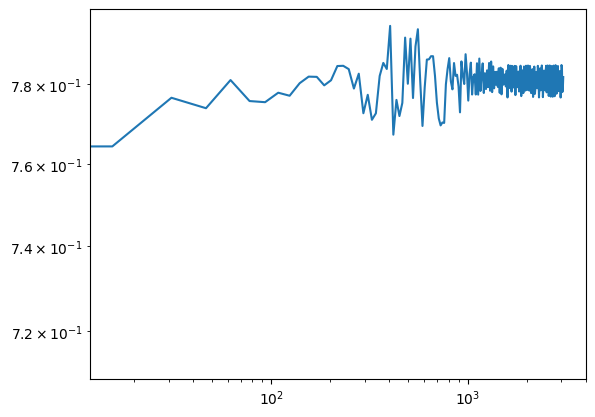

In [135]:
plt.loglog(consts.ell, ratio)

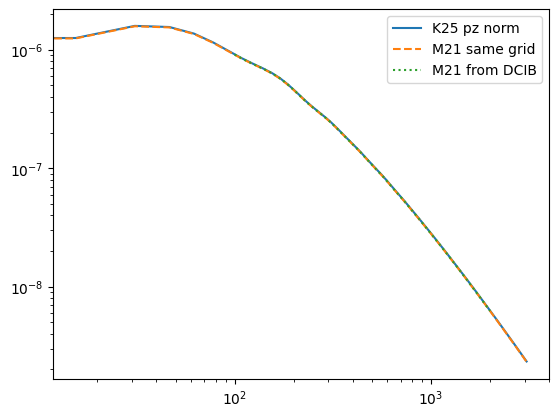

In [148]:
plt.loglog(consts.ell,
           cl2h_k25_no_mag_bias_pz_norm,label='K25 pz norm')
plt.loglog(consts.ell,
           cl2h_m21_same_grid,label='M21 same grid',
           ls='--')
plt.loglog(gal_obj_m21.ell,
           cl2h_m21_from_DCIB,label='M21 from DCIB',
           ls='dotted')
plt.legend(loc='best')

Therefore, the 2-halo terms match within tolerance. 

#### 1-halo term

In [149]:
# from M21 
cl1h_m21_from_DCIB = gal_obj_m21.cl1h_gal()

In [152]:
# from K25
pk1h_k25 = ps.galcrossgal_pk_1h(galterm_k25, 
                     nbar_halo_k25, ncen_k25)
pk1h_k25.shape

(199, 102)

In [154]:
# calculate Cl1h for K25 without mag bias and pz norm
cl1h_k25 = simpson(pk1h_k25 * prefact_gg_no_mbias_pz_norm,
                   x=ps.z_all, axis=-1)

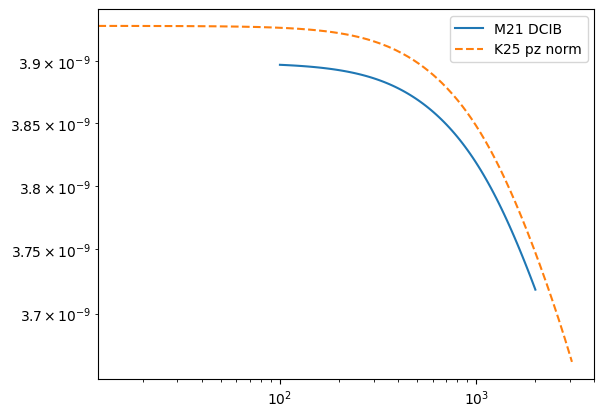

In [211]:
plt.loglog(gal_obj_m21.ell, cl1h_m21_from_DCIB,
           label = 'M21 DCIB')
plt.loglog(consts.ell, cl1h_k25, label = 'K25 pz norm',
           ls = '--')
plt.legend(loc='best')

In [212]:
cl1h_k25_interp = np.interp(gal_obj_m21.ell,
                            consts.ell,
                            cl1h_k25)

In [213]:
np.abs(cl1h_k25_interp/cl1h_m21_from_DCIB-1)*100

array([0.77520613, 0.77521109, 0.77529147, 0.77533667, 0.77520111,
       0.77515036, 0.77519027, 0.77532741, 0.77517685, 0.77510489,
       0.77514411, 0.77526603, 0.77509978, 0.77506174, 0.77516352,
       0.77510191, 0.77501676, 0.77509159, 0.77506868, 0.77497713,
       0.77506897, 0.77499347, 0.77494746, 0.77507883, 0.77490958,
       0.77497234, 0.77491315, 0.77489189, 0.7749196 , 0.7748483 ,
       0.77490223, 0.77482096, 0.77486292, 0.77479843, 0.77481055,
       0.77479358, 0.77475178, 0.77483814, 0.77471436, 0.77473744,
       0.77475993, 0.77467246, 0.77469297, 0.77474842, 0.77465344,
       0.77464387, 0.77464609, 0.77464205, 0.77466846, 0.77463412,
       0.7745873 , 0.77459312, 0.7745888 , 0.77455317, 0.77456531,
       0.77457109, 0.77453638, 0.77455281, 0.77457799, 0.77452544,
       0.77451897, 0.7745415 , 0.77450924, 0.77449973, 0.77453065,
       0.77449768, 0.77447196, 0.77453481, 0.77447164, 0.77445802,
       0.77451303, 0.77446399, 0.77443638, 0.77450389, 0.77446

Therefore, the 1-halo terms match to tolerance level of 0.8%

### Combining all

In [214]:
cl_k25_tot = cl1h_k25 + cl2h_k25_no_mag_bias_pz_norm

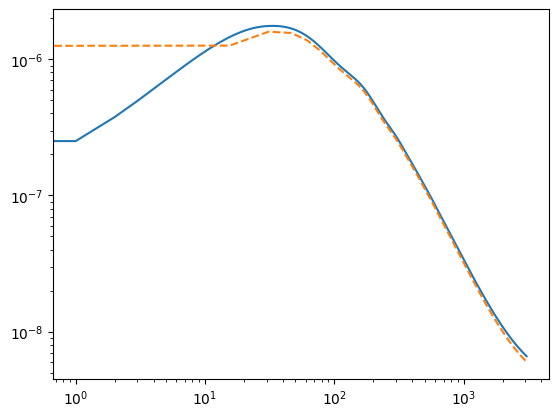

In [218]:
plt.loglog(np.arange(3071), c_all_k25[0])
plt.loglog(consts.ell, cl_k25_tot, ls = '--')

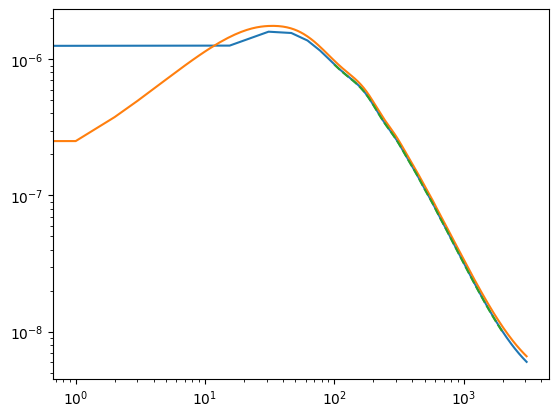

In [222]:
plt.loglog(consts.ell, cl_k25_tot)
plt.loglog(np.arange(3071), c_all_k25[0])
plt.loglog(gal_obj_m21.ell, gal_obj_m21.cl_galtot(),
           ls='--')

In [223]:
cl_k25_tot.shape

(199,)

In [224]:
from scipy.interpolate import CubicSpline
spl = CubicSpline(consts.ell, cl_k25_tot)
cl_k25_tot_interp = spl(np.arange(3071))

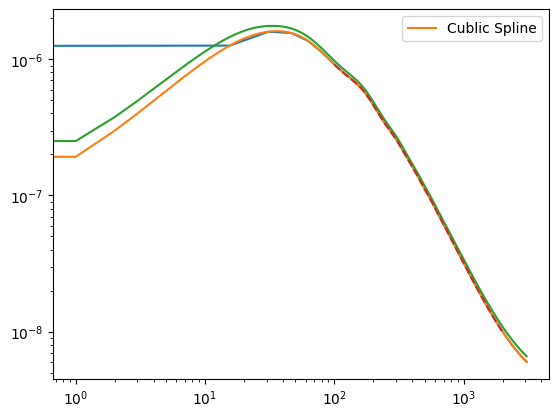

In [227]:
plt.loglog(consts.ell, cl_k25_tot)
plt.loglog(np.arange(3071), cl_k25_tot_interp, label = 'Cublic Spline')
plt.loglog(np.arange(3071), c_all_k25[0])
plt.loglog(gal_obj_m21.ell, gal_obj_m21.cl_galtot(),
           ls='--')
plt.legend(loc='best')

Therefore, we have verified that $C_{\rm gg}$ works.

# Component 2: $C_{\rm CIB-CIB}$

In [12]:
cib_obj_m21 = mcib.Cib_halo(data_var_iv, cosmo_var)

# CIB X CIB
cII_m21 = cib_obj_m21.cl_cibtot()

pkt shape = (102, 99)


In [9]:
# CIB X CIB 
cII_m21 = cib_obj_m21.cl_cibtot()
cII_k25 = c_all_k25[4:]

pkt shape = (102, 99)


NameError: name 'c_all_k25' is not defined

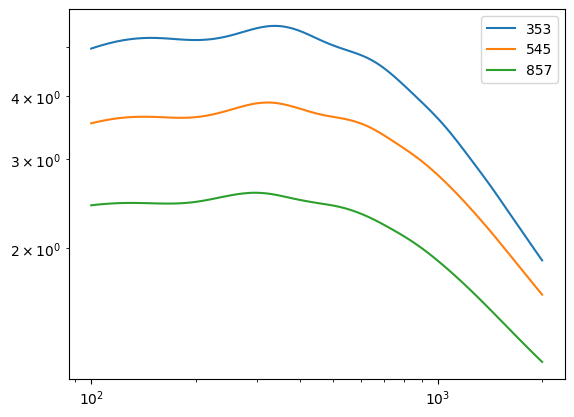

In [11]:
# -1,-1 is 857x857 in DopplerCIB

cII_interped = np.interp(cib_obj_m21.ell,
                         np.arange(3071), cII_k25[0])
plt.loglog(cib_obj_m21.ell, cII_interped/cII_m21[3,3],
           label = '353')

cII_interped = np.interp(cib_obj_m21.ell,
                         np.arange(3071), cII_k25[3])
plt.loglog(cib_obj_m21.ell, cII_interped/cII_m21[4,4],
           label = '545')

cII_interped = np.interp(cib_obj_m21.ell,
                         np.arange(3071), cII_k25[5])
plt.loglog(cib_obj_m21.ell, cII_interped/cII_m21[5,5],
           label = '857')

plt.legend(loc='best')


Therefore, there is a significant difference between the two codes.

### Central emissivity

In [12]:
djc_m21 = cib_obj_m21.djc_dlnMh()

In [21]:
## calculate the central and sat CIB terms 

# need unfw profile 
unfw_k25 = halo.nfwfourier_u(lambda_NFW=1, rad200=pc.rad200, 
                             c=pc.concentration, 
                             c_term=pc.concentration_amp)  


cibterm_k25, djc_k25, djsub_k25 = cib.cibterm(cib_params, unfw_k25, 'M21')

In [14]:
ratio = np.abs(djc_k25.value/djc_m21[3:])
ratio.shape

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_41186/3863840979.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = np.abs(djc_k25.value/djc_m21[3:])


(3, 100, 102)

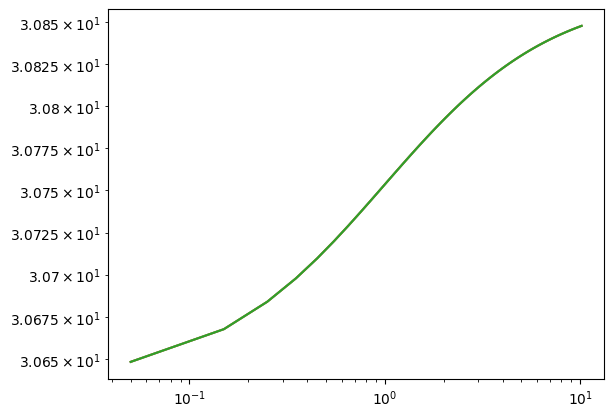

In [15]:
zidx = 11
midx = 50
for i in range(3):
    #plt.loglog(consts.Mh_Msol, ratio[i,:,zidx])
    plt.loglog(consts.Plin['z'], ratio[i,midx,:])

Clearly, the central emissivity does not match. 

#### Check central emissivity component by component

In [16]:
# confirm mass
cib_obj_m21.mh/consts.Mh_Msol

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [17]:
# confirm S_nu
np.sum(consts.snu_eff_z/cib_obj_m21.snu[3:])/consts.snu_eff_z.size

1.0

In [18]:
# confirm fsub 
consts.fsub

0.134

In [19]:
# confirm KC 
consts.KC

1e-10

### SFR comparison

In [20]:
cib_obj_m21.etamax

0.4153424663501908

In [21]:
cib_params

array([ 0.49, 11.52, -0.02,  2.74,  0.5 ,  2.15, 11.38,  0.4 ])

We notice that the built-in CIB values in `DopplerCIB` are different from `galCIB`

Therefore, we re-update `galCIB` with the `CIB_halo.py` hard-coded values in `DopplerCIB`.

In [22]:
cib_params = np.array([0.49, 11.52, #etamax, mu_peak0,
                       -0.02, 2.74, # mu_peakp, sigma_M0,
                       0.5, 2.15, 11.38, # tau, zc,
                       0.4]) 
# SFR (6):  
# ,  Mmin_IR, IR_sigma_lnM

In [23]:
etamax_m21 = cib_obj_m21.etamax
mu_peak0_m21 = np.log10(cib_obj_m21.Meffmax)
mu_peakp_m21 = 0
sigma_M0_m21 = cib_obj_m21.sigmaMh
tau_m21 = cib_obj_m21.tau
zc_m21 = cib_obj_m21.z_c


In [24]:
cib_params_m21 = np.array([etamax_m21, mu_peak0_m21,
                           mu_peakp_m21, sigma_M0_m21,
                           tau_m21, zc_m21,
                           11.38, 0.4])

In [25]:
sfr_m21 = cib_obj_m21.sfr(consts.Mhc_Msol)
sfr_k25 = cib.SFR(etamax_m21, mu_peak0_m21,
                           mu_peakp_m21, sigma_M0_m21,
                           tau_m21, zc_m21,)

In [26]:
ratio = sfr_k25/sfr_m21
ratio.shape

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_41186/2775764843.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = sfr_k25/sfr_m21


(100, 102)

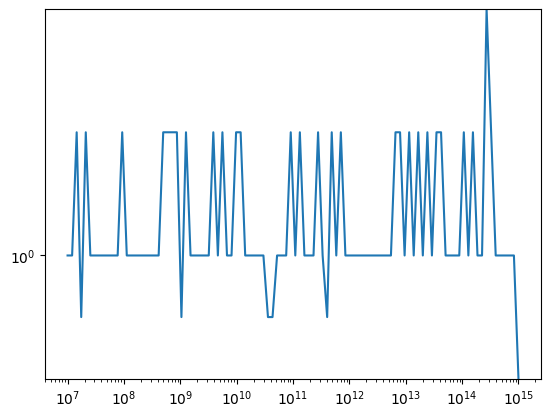

In [27]:
zidx = 11
midx = 55

plt.loglog(consts.Mh_Msol, ratio[:,zidx])

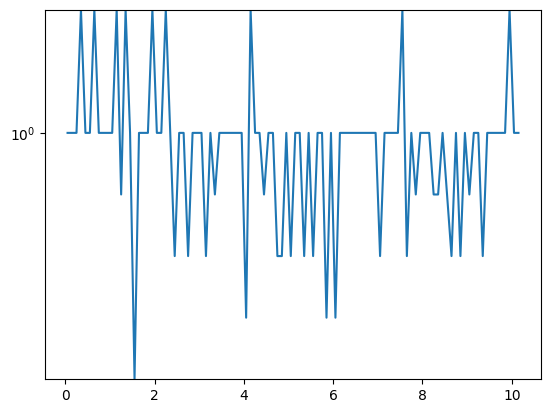

In [28]:
plt.semilogy(consts.Plin['z'], ratio[midx,:])

In [29]:
ratio[~np.isnan(ratio)].sum()/len(ratio[~np.isnan(ratio)])

1.0

Therefore, we get the exact SFR when we use the CIB values from `DopplerCIB`.

## Updated CIB-CIB

Let us re-check the CIB-CIB power spectra using these updated SFR parameters. 

In [8]:
etamax_m21 = cib_obj_m21.etamax
mu_peak0_m21 = np.log10(cib_obj_m21.Meffmax)
mu_peakp_m21 = 0
sigma_M0_m21 = cib_obj_m21.sigmaMh
tau_m21 = cib_obj_m21.tau
zc_m21 = cib_obj_m21.z_c

cib_params_m21 = np.array([etamax_m21, mu_peak0_m21,
                           mu_peakp_m21, sigma_M0_m21,
                           tau_m21, zc_m21,
                           11.38, 0.4])

In [9]:
# 1- to 2- halo smoothing transition parameter is set to 1; but Mead++20 finds this to be 0.7 at z~0
hmalphas = np.ones(10) 

# shotnoise defined over log10 for sampling efficiency; 
# define as log10(N_shot/Jy/sr) = theta_shot;
# use unWISE green best-fit value because it is closest to ELG p(z)
shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = shotnoise_gCIB - 2 # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.log10(np.array([225, 543, 913, 1454, 2655, 5628]))
shotnoise_all = np.concatenate((shotnoise_gCIB, shotnoise_CIBCIB))

# physical parameters of importance
gal_params = np.array([gal_obj_m21.gamma, gal_obj_m21.log10mc, gal_obj_m21.sLog10m, gal_obj_m21.Ac, # Ncen (4): gamma, log10Mc, sigmaM, Ac
                       gal_obj_m21.As, np.log10(gal_obj_m21.m0), gal_obj_m21.m1, gal_obj_m21.alpha_]) # Nsat (4): As, M0, M1, alpha
prof_params = np.array([0., 6.14, 1]) # fexp, tau, lambda_NFW

# use the SFR values from M21
all_params_m21 = np.concatenate((hmalphas, shotnoise_all, 
                                 gal_params, prof_params, 
                                 cib_params_m21))

In [10]:
c_all_k25_sfr_m21 = ps.c_all(theta=all_params_m21,
                             cib_model='M21')

# select all the CIB-CIB power spectra
cII_k25_sfr_m21 = c_all_k25_sfr_m21[4:]

you set meanIR to 1 by hand for testing.


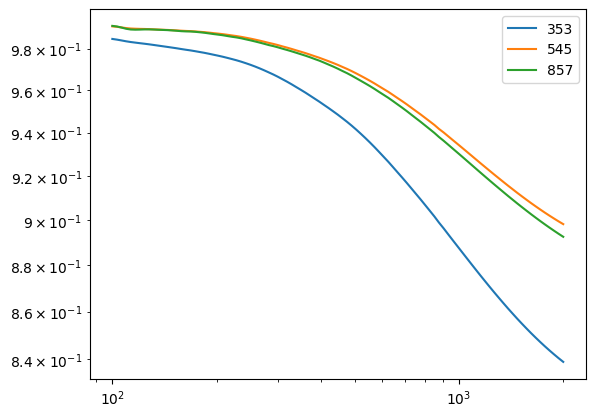

In [13]:
# -1,-1 is 857x857 in DopplerCIB

cII_interped = np.interp(cib_obj_m21.ell,
                         np.arange(3071), cII_k25_sfr_m21[0])
plt.loglog(cib_obj_m21.ell, cII_interped/cII_m21[3,3],
           label = '353')

cII_interped = np.interp(cib_obj_m21.ell,
                         np.arange(3071), cII_k25_sfr_m21[3])
plt.loglog(cib_obj_m21.ell, cII_interped/cII_m21[4,4],
           label = '545')

cII_interped = np.interp(cib_obj_m21.ell,
                         np.arange(3071), cII_k25_sfr_m21[5])
plt.loglog(cib_obj_m21.ell, cII_interped/cII_m21[5,5],
           label = '857')

plt.legend(loc='best')


Discrepancy is less but still persists. 

### Updated CIBterm

In [14]:
# emissivity terms from M21

djc_m21 = cib_obj_m21.djc_dlnMh()
djsub_m21 = cib_obj_m21.djsub_dlnMh()

In [15]:
## calculate the central and sat CIB terms 

# need unfw profile 
unfw_k25 = halo.nfwfourier_u(lambda_NFW=1, rad200=pc.rad200, 
                             c=pc.concentration, 
                             c_term=pc.concentration_amp)  


cibterm_k25_sfr_m21, djc_k25_sfr_m21, djsub_k25_sfr_m21 = cib.cibterm(cib_params_m21, 
                                              unfw_k25, 'M21')

you set meanIR to 1 by hand for testing.


In [16]:
ratio = np.abs(djc_k25_sfr_m21.value/djc_m21[3:])
ratio.shape

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_62339/1050827679.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = np.abs(djc_k25_sfr_m21.value/djc_m21[3:])


(3, 100, 102)

In [17]:
ratio[~np.isnan(ratio)].sum()/len(ratio[~np.isnan(ratio)])

1.0

Therefore, the central emissivity term $dj_c$ matches exactly.

#### subhalo emissivity $dj_{\rm sub}$

In [18]:
djsub_m21 = cib_obj_m21.djsub_dlnMh()

In [19]:
djsub_m21.shape

(6, 100, 102)

In [20]:
ratio = djsub_k25_sfr_m21.value/djsub_m21[3:]

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_62339/4287154952.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = djsub_k25_sfr_m21.value/djsub_m21[3:]


In [21]:
ratio

array([[[1.00373163, 1.00373163, 1.00373163, ..., 1.00373163,
         1.00373163, 1.00373163],
        [1.00591077, 1.00591077, 1.00591077, ..., 1.00591077,
         1.00591077, 1.00591077],
        [1.09450859, 1.09450859, 1.09450859, ..., 1.09450859,
         1.09450859, 1.09450859],
        ...,
        [1.00019074, 1.00015144, 1.00012748, ..., 1.00018006,
         1.00018006, 1.00018006],
        [1.00015419, 1.00015591, 1.00010557, ..., 0.99964184,
         0.99964184, 0.99964184],
        [1.00008657, 1.0000765 , 1.0000534 , ..., 1.00010804,
         1.00010804, 1.00010804]],

       [[1.00373163, 1.00373163, 1.00373163, ..., 1.00373163,
         1.00373163, 1.00373163],
        [1.00591077, 1.00591077, 1.00591077, ..., 1.00591077,
         1.00591077, 1.00591077],
        [1.09450859, 1.09450859, 1.09450859, ..., 1.09450859,
         1.09450859, 1.09450859],
        ...,
        [1.00019074, 1.00015144, 1.00012748, ..., 1.00018006,
         1.00018006, 1.00018006],
        [1.0

In [22]:
ratio[~np.isnan(ratio)].sum()/len(ratio[~np.isnan(ratio)])

1.0066331248090343

Value is practically the same. 

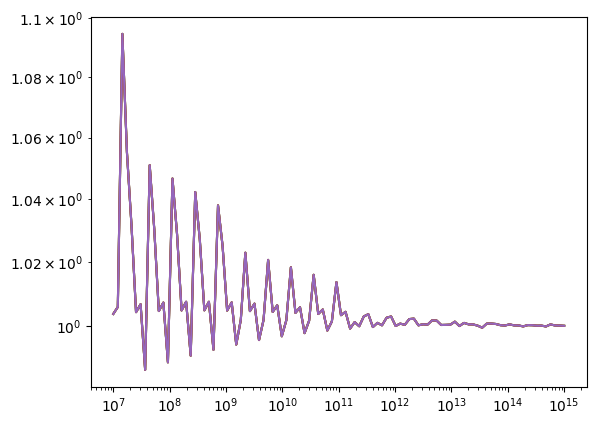

In [23]:
zidx = 11
midx = 50
for midx in [1, 5, 10, 50, 99]:
    plt.loglog(consts.Mh_Msol, ratio[0,:,zidx])

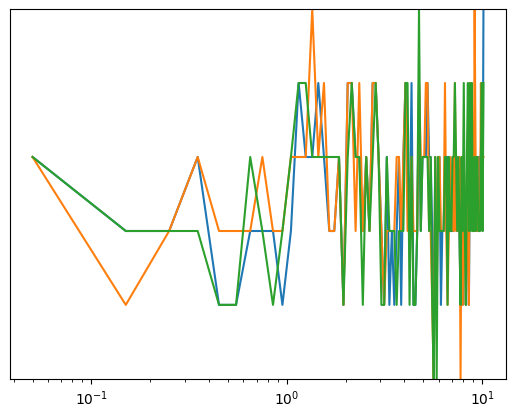

In [24]:
zidx = 11
midx = 50
for i in range(3):
    plt.loglog(consts.Plin['z'], ratio[i,midx,:])

There seems to be a mass-dependent structure in the subhalo SFR. What could this be? 

Also noticed that the `twohalo_int` in `CIB_halo.py` under `DopplerCIB` may be calling slightly different values so test this function as a sandbox to check for agreements.

First we start with `J_nu` as this is similar to the `cibterm` function in `galCIB`. 

In [25]:
from scipy.integrate import simpson

In [26]:
def J_nu_m21():  # , Meffmax, etamax, sigmaMh, alpha):
    nfreq = len(consts.nu0) # use K25 freq
    nl = len(consts.ell) # use K25 ell 
    Jnu = np.zeros((nfreq, len(consts.Plin['z']), nl))
    dj_cen, dj_sub = cib_obj_m21.djc_dlnMh()[3:], cib_obj_m21.djsub_dlnMh()[3:]
    print(dj_cen.shape)
    print(dj_sub.shape)
    #u = cib_obj_m21.unfw
    u = np.swapaxes(unfw_k25,0,1)
    print(u[:,0,:].shape)
    dm = np.log10(cib_obj_m21.mh[1] / cib_obj_m21.mh[0])
    for i in range(nl):
        rest1 = (dj_cen + dj_sub*u[:, i, :])*cib_obj_m21.biasmz*cib_obj_m21.hmfmz
        intg_mh = simpson(rest1, dx=dm, axis=1)
        Jnu[:, :, i] = intg_mh
    return Jnu

In [27]:
def twohalo_int():  # , snu_eff, ell, unfw, power, fc, cc):
    nfreq = len(consts.nu0)
    nl = len(consts.ell)
    Cl_2h = np.zeros((nfreq, nfreq, nl))
    Jv = J_nu_m21()
    geo = cib_obj_m21.uni.dchi_dz(cib_obj_m21.z)/(cib_obj_m21.uni.chi(cib_obj_m21.z)*(1+cib_obj_m21.z))**2
    power = cib_obj_m21.uni.Pk_array(cib_obj_m21.ell, cib_obj_m21.z)
    pk_geo = power*geo  # multiplying by geometric factor here itself
    # because in the next step we are going to transpose power spectrum
    # and then we can't multiply dimension (z,ell) with (z,)
    pkt = np.transpose(pk_geo)  # power dimensions are (ell, z) and
    # here we need dimensions of (z, ell). o transpose
    print(f'pkt shape = {pkt.shape}')
    for f in range(nfreq):
        rest1 = Jv*Jv[f, :, :]*pkt
        # rest1[:, :5, :] = 0  # cutting contribn from 0 to 0.5 redshift
        intg_z = simpson(rest1, x=self.z, axis=1)
        fcxcc = cib_obj_m21.fc*cib_obj_m21.cc
        Cl_2h[f, :, :] = fcxcc[f]*intg_z*fcxcc[:, None]
    return Cl_2h#, geo, power

Since we are using our own Pk_int, make sure the $P_{mm}$ match within tolerance.

In [28]:
for zidx in range(len(consts.Plin['z'])):
    pmm_k25_interp = np.interp(cib_obj_m21.ell, 
                           consts.ell,
                           consts.Pk_array_over_ell[:,zidx]
                           )
    ratio = 100*np.abs(pmm_k25_interp/power[:,zidx] - 1)
    
    bad_sum = (ratio > 0.5).sum()
    
    if bad_sum > 0:
        print(zidx)

NameError: name 'power' is not defined

In [128]:
zidx = 2

pmm_k25_interp = np.interp(cib_obj_m21.ell, 
                    consts.ell,
                    consts.Pk_array_over_ell[:,zidx]
                    )
ratio = 100*np.abs(pmm_k25_interp/power[:,zidx] - 1)

Therefore, some power spectra, especially low-z do not match at certain k values.

In [52]:
def twohalo_int():  # , snu_eff, ell, unfw, power, fc, cc):
    nfreq = len(consts.nu0)
    nl = len(consts.ell)
    Cl_2h = np.zeros((nfreq, nfreq, nl))
    Jv = J_nu_m21()
    geo = cib_obj_m21.uni.dchi_dz(cib_obj_m21.z)/(cib_obj_m21.uni.chi(cib_obj_m21.z)*(1+cib_obj_m21.z))**2
    #power = cib_obj_m21.uni.Pk_array(cib_obj_m21.ell, cib_obj_m21.z)
    power = consts.Pk_array_over_ell
    pk_geo = power*geo  # multiplying by geometric factor here itself
    # because in the next step we are going to transpose power spectrum
    # and then we can't multiply dimension (z,ell) with (z,)
    pkt = np.transpose(pk_geo)  # power dimensions are (ell, z) and
    # here we need dimensions of (z, ell). o transpose
    print(f'pkt shape = {pkt.shape}')
    for f in range(nfreq):
        rest1 = Jv*Jv[f, :, :]*pkt
        # rest1[:, :5, :] = 0  # cutting contribn from 0 to 0.5 redshift
        intg_z = simpson(rest1, x=cib_obj_m21.z, axis=1)
        fcxcc = cib_obj_m21.fc[3:]*cib_obj_m21.cc[3:]
        Cl_2h[f, :, :] = fcxcc[f]*intg_z*fcxcc[:, None]
        #Cl_2h[f, :, :] = intg_z
    return Cl_2h#, geo, power

In [53]:
cl2h_II_m21 = twohalo_int()

(3, 100, 102)
(3, 100, 102)
(100, 102)
pkt shape = (102, 199)


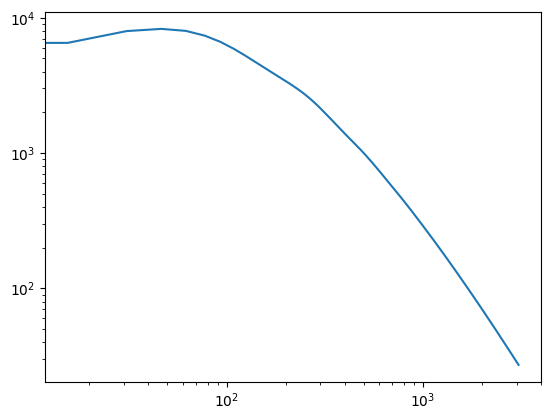

In [54]:
plt.loglog(consts.ell, cl2h_II_m21[0,0],
           label = 'M21')

In [55]:
pk2h_k25_sfr_m21 = ps.cibcrosscib_pk_2h(cibterm_k25_sfr_m21)

In [56]:
tmp_integrand = ps.prefact_cibcib*pk2h_k25_sfr_m21
tmp_integrand.shape

(3, 3, 199, 102)

In [57]:
c2h_II_k25_sfr_m21 = simpson(tmp_integrand,x=consts.Plin['z'],
                             axis=-1)
c2h_II_k25_sfr_m21.shape

(3, 3, 199)

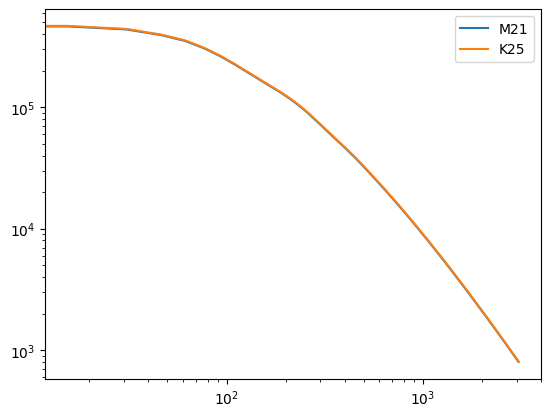

In [59]:
plt.loglog(consts.ell, cl2h_II_m21[2,2],
           label = 'M21')
plt.loglog(consts.ell, c2h_II_k25_sfr_m21[2,2],
           label = 'K25')
plt.legend(loc='best')

In [36]:
for f1 in range(3):
    for f2 in range(3):
        ratio = 100*np.abs(c2h_II_k25_sfr_m21[f1,f2]/cl2h_II_m21[f1,f2] - 1)
        
        bad_sum = (ratio > 0.5).sum()
        
        if bad_sum > 0:
            print(f1,f2)

Therefore, all 2-halo terms match.

##### One-halo comparison

In [37]:
pk1h_k25_sfr_m21 = ps.cibcrosscib_pk_1h(djc_k25_sfr_m21,
                                        djsub_k25_sfr_m21,
                                        unfw_k25)

In [38]:
pk1h_k25_sfr_m21.shape

(3, 3, 199, 102)

In [69]:
def onehalo_int():
    nfreq = len(consts.nu0)
    nl = len(consts.ell)
    Cl_1h = np.zeros((nfreq, nfreq, nl))
    dj_cen, dj_sub = cib_obj_m21.djc_dlnMh()[3:], cib_obj_m21.djsub_dlnMh()[3:]
    #u = self.unfw
    u = np.swapaxes(unfw_k25,0,1)
    geo = cib_obj_m21.uni.dchi_dz(cib_obj_m21.z)/(cib_obj_m21.uni.chi(cib_obj_m21.z)*(1+cib_obj_m21.z))**2
    dm = np.log10(cib_obj_m21.mh[1] / cib_obj_m21.mh[0])
    fcxcc = cib_obj_m21.fc[3:]*cib_obj_m21.cc[3:]
    for i in range(nl):
        for f in range(nfreq):
            rest1 = (dj_cen[f, :, :]*dj_sub*u[:, i, :] + dj_cen *
                        dj_sub[f, :, :]*u[:, i, :] + dj_sub[f, :, :] *
                        dj_sub*u[:, i, :]**2)*cib_obj_m21.hmfmz
            intg_mh = simpson(rest1, dx=dm, axis=1)
            intg_z = simpson(intg_mh*geo, x=cib_obj_m21.z, axis=-1)
            Cl_1h[f, :, i] = fcxcc[f]*intg_z*fcxcc
            #Cl_1h[f, :, i] = intg_z
    
    return Cl_1h

In [70]:
cl1h_II_m21 = onehalo_int()
cl1h_II_m21.shape

(3, 3, 199)

In [71]:
tmp_integrand = ps.prefact_cibcib*pk1h_k25_sfr_m21
c1h_II_k25_sfr_m21 = simpson(tmp_integrand,x=consts.Plin['z'],
                             axis=-1)
c1h_II_k25_sfr_m21.shape

(3, 3, 199)

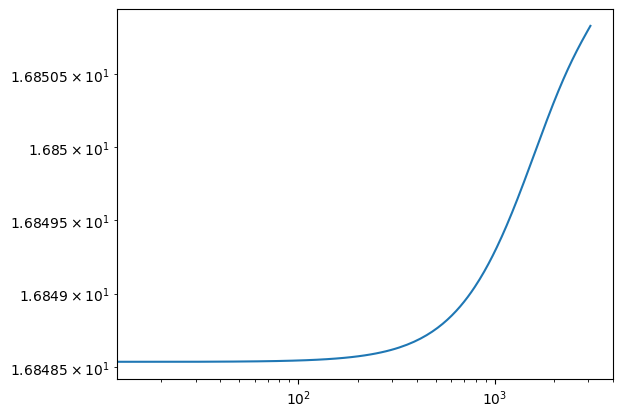

In [72]:
ratio = 100*np.abs(c1h_II_k25_sfr_m21[0,0]/cl1h_II_m21[0,0]-1)
plt.loglog(consts.ell, ratio)

In [43]:
for f1 in range(3):
    for f2 in range(3):
        ratio = 100*np.abs(c1h_II_k25_sfr_m21[f1,f2]/cl1h_II_m21[f1,f2] - 1)
        
        bad_sum = (ratio > 0.5).sum()
        
        if bad_sum > 0:
            print(f1,f2)

Therefore, the one-halo term also matches

In [73]:
def cl_cibtot():
    oneh = onehalo_int()  # snu_eff, ell, unfw, fc, cc)
    twoh = twohalo_int()  # snu_eff, ell, unfw, power, fc, cc)
    tot = oneh+twoh
    return tot

In [74]:
cl_II_tot_m21 = cl_cibtot()
cl_II_tot_m21.shape

(3, 100, 102)
(3, 100, 102)
(100, 102)
pkt shape = (102, 199)


(3, 3, 199)

In [75]:
cl_II_tot_k25_sfr_m21 = ps.cibcrosscib_cell_tot(hmalpha_cibcib=np.ones(6)[:,np.newaxis,np.newaxis],
                                        cibterm=cibterm_k25_sfr_m21,
                                        djc=djc_k25_sfr_m21,
                                        djsub=djsub_k25_sfr_m21,
                                        uprof=unfw_k25,
                                        shotnoise=np.zeros(6))

In [76]:
cl_II_tot_k25_sfr_m21.shape

(6, 199)

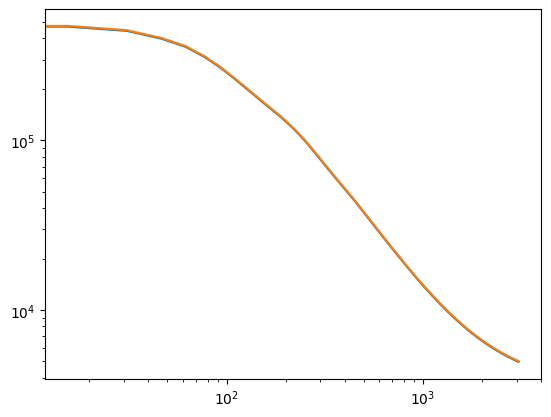

In [78]:
plt.loglog(consts.ell, cl_II_tot_m21[2,2],label='M21')
plt.loglog(consts.ell, cl_II_tot_k25_sfr_m21[-1],label='k25')

In [50]:
# Get the upper-triangular indices
triu_i, triu_j = np.triu_indices(3)

# Extract upper triangle of A into shape (M, X) to compare with B
cl_II_tot_m21_triu = cl_II_tot_m21[triu_i, triu_j, :]  # shape (M, X)

# Now do the comparison
ratio = 100 * np.abs((cl_II_tot_m21_triu/cl_II_tot_k25_sfr_m21) - 1)

In [51]:
(ratio > 0.5).sum(axis=1)

array([0, 0, 0, 0, 0, 0])

Therefore, the CIB-CIB match.

#### Plug best-fit to `DopplerCIB`

In [80]:
etamax_m21 = cib_obj_m21.etamax
mu_peak0_m21 = np.log10(cib_obj_m21.Meffmax)
mu_peakp_m21 = 0
sigma_M0_m21 = cib_obj_m21.sigmaMh
tau_m21 = cib_obj_m21.tau
zc_m21 = cib_obj_m21.z_c


In [81]:
cib_obj_m21_updated = mcib.Cib_halo(data_var_iv, cosmo_var)

In [82]:
cl_II_m21_updated = cib_obj_m21_updated.cl_cibtot()

pkt shape = (102, 99)


In [83]:
cl_II_m21_updated.shape

(6, 6, 99)

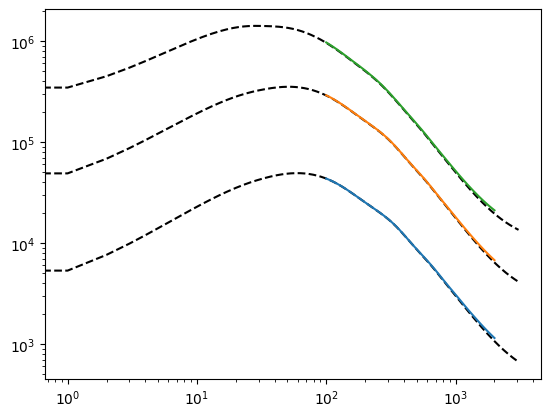

In [87]:
plt.loglog(np.arange(3071), c_all_k25[4],
           ls = '--', c = 'k')

plt.loglog(np.arange(3071), c_all_k25[7],
           ls = '--', c = 'k')

plt.loglog(np.arange(3071), c_all_k25[9],
           ls = '--', c = 'k')

for i in range(3,6):
    plt.loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[i,i])
    


Therefore, Y23 predicted a much higher CIB-CIB than anticipated.

## Overlay Lenz+19 values to check theory against data

In [88]:
df_cib_auto = pd.read_csv("data/cib/Cl_CIB_T1T2.csv", comment='#')

Text(0.5, 1.0, '857x857')

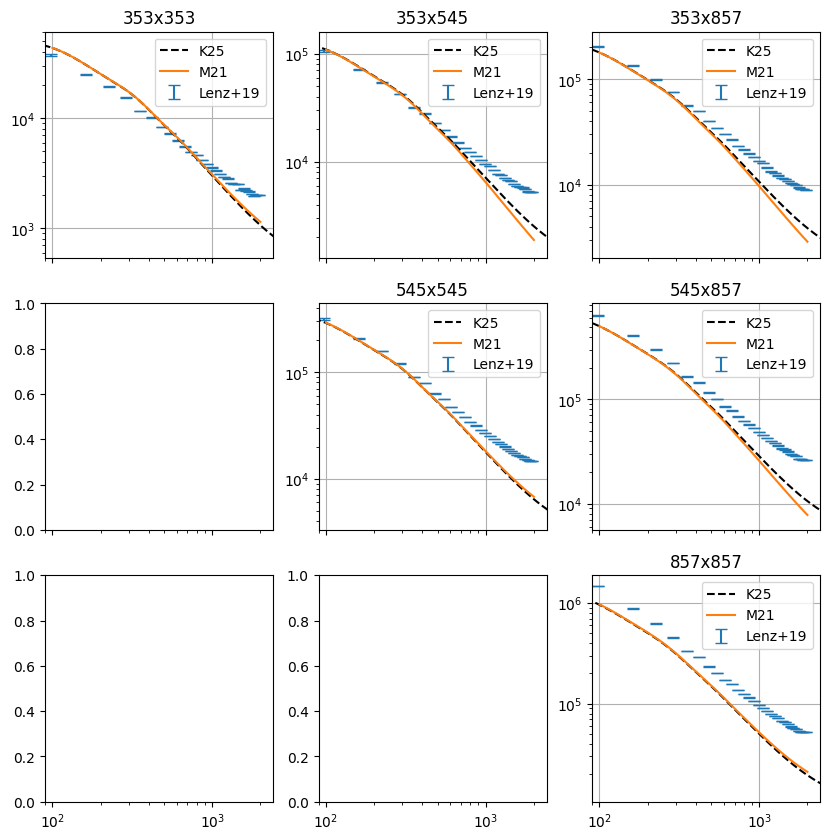

In [126]:
fig, ax = plt.subplots(3,3, figsize = (10,10),
                                    sharex=True)
#fig.suptitle('Horizontally stacked subplots')

fsky_approx = .30

## 353x353
ax[0,0].errorbar(
    df_cib_auto['ell'],
    df_cib_auto['353x353']/fsky_approx,
    yerr=df_cib_auto['d353x353'],
    ls="None",
    capsize=4,
    label = 'Lenz+19')
ax[0,0].grid()

ax[0,0].loglog(np.arange(3071), c_all_k25[4],
           ls = '--', c = 'k',
           label = 'K25') # K25 theory

# M21 theory 
ax[0,0].loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[3,3],
               label='M21')
ax[0,0].set_xlim([90,2400])

ax[0,0].legend(loc='best')
ax[0,0].set_title("353x353")

## 353x545
ax[0,1].errorbar(
    df_cib_auto['ell'],
    df_cib_auto['353x545']/fsky_approx,
    yerr=df_cib_auto['d353x545'],
    ls="None",
    capsize=4,
    label = 'Lenz+19')
ax[0,1].grid()

ax[0,1].loglog(np.arange(3071), c_all_k25[5],
           ls = '--', c = 'k',
           label = 'K25') # K25 theory

# M21 theory 

ax[0,1].loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[3,4],
               label='M21')

ax[0,1].legend(loc='best')
ax[0,1].set_title("353x545")

## 353x857
ax[0,2].errorbar(
    df_cib_auto['ell'],
    df_cib_auto['353x857']/fsky_approx,
    yerr=df_cib_auto['d353x857'],
    ls="None",
    capsize=4,
    label = 'Lenz+19')
ax[0,2].grid()

ax[0,2].loglog(np.arange(3071), c_all_k25[6],
           ls = '--', c = 'k',
           label = 'K25') # K25 theory

# M21 theory 

ax[0,2].loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[3,5],
               label='M21')

ax[0,2].legend(loc='best')
ax[0,2].set_title("353x857")

## 545x545
ax[1,1].errorbar(
    df_cib_auto['ell'],
    df_cib_auto['545x545']/fsky_approx,
    yerr=df_cib_auto['d545x545'],
    ls="None",
    capsize=4,
    label = 'Lenz+19')
ax[1,1].grid()

ax[1,1].loglog(np.arange(3071), c_all_k25[7],
           ls = '--', c = 'k',
           label = 'K25') # K25 theory

# M21 theory 

ax[1,1].loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[4,4],
               label='M21')

ax[1,1].legend(loc='best')
ax[1,1].set_title("545x545")

## 545x857
ax[1,2].errorbar(
    df_cib_auto['ell'],
    df_cib_auto['545x857']/fsky_approx,
    yerr=df_cib_auto['d545x857'],
    ls="None",
    capsize=4,
    label = 'Lenz+19')
ax[1,2].grid()

ax[1,2].loglog(np.arange(3071), c_all_k25[8],
           ls = '--', c = 'k',
           label = 'K25') # K25 theory

# M21 theory 

ax[1,2].loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[4,5],
               label='M21')

ax[1,2].legend(loc='best')
ax[1,2].set_title("545x857")

## 857x857
ax[2,2].errorbar(
    df_cib_auto['ell'],
    df_cib_auto['857x857']/fsky_approx,
    yerr=df_cib_auto['d857x857'],
    ls="None",
    capsize=4,
    label = 'Lenz+19')
ax[2,2].grid()

ax[2,2].loglog(np.arange(3071), c_all_k25[9],
           ls = '--', c = 'k',
           label = 'K25') # K25 theory

# M21 theory 

ax[2,2].loglog(cib_obj_m21_updated.ell,
               cl_II_m21_updated[5,5],
               label='M21')

ax[2,2].legend(loc='best')
ax[2,2].set_title("857x857")

In [117]:
import healpy as hp

In [118]:
# CIB1 X CIB2

healpy_data_path = '../healpy-weights/'
nulist = ['353', '545', '857']

cl_cibxcib_odd_even = {}
fsky_auto = {}

for nu_odd in nulist:
    for nu_even in nulist: 
        # read odd and even map for auto power spectra and multiply by 1e6 to convert Jy to mJy 
        #oddring = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu_odd}/cib_oddring.hpx.fits")*1e6
        #evenring = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu_even}/cib_evenring.hpx.fits")*1e6

        mask_bool_odd = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu_odd}/mask_bool.hpx.fits", dtype=bool)
        mask_bool_even = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu_even}/mask_bool.hpx.fits", dtype=bool)
        mask_apod_odd = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu_odd}/mask_apod.hpx.fits")
        mask_apod_even = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu_even}/mask_apod.hpx.fits")

        fsky_auto[nu_odd] = mask_bool_odd.sum()/len(mask_bool_odd)
        
        # cl_odd_even = hp.anafast(
        #     map1=np.where(mask_bool_odd, oddring, 0.) * mask_apod_odd,
        #     map2=np.where(mask_bool_even, evenring, 0.) * mask_apod_even,
        #     datapath=healpy_data_path, use_pixel_weights=True, pol = False)
            
        # cl_cibxcib_odd_even[f'{nu_odd}x{nu_even}'] = cl_odd_even

In [121]:
# now calculate the cross with fullmission and compare where nu != nu'

cl_cibxcib_fullmission = {}
cl_cibxcib_fullmission_beam_corrected = {}
fsky_cross = {}

for nu1 in nulist:
    for nu2 in nulist: 
        
        if nu1 == nu2: # ignore nu == nu' because of auto-noise
            continue 
        
        if int(nu1) > int(nu2): # ignore double counting 
            continue
        
        # multiply by 1e6 to convert Jy to mJy 
        #nu1_map = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu1}/cib_fullmission.hpx.fits")*1e6
        #nu2_map = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu2}/cib_fullmission.hpx.fits")*1e6

        # read in relevant masks and calculate effective fsky
        mask_bool1 = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu1}/mask_bool.hpx.fits", dtype=bool)
        mask_bool2 = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu2}/mask_bool.hpx.fits", dtype=bool)
        mask_bool_eff = mask_bool1 * mask_bool2
        fsky_cross[f'{nu1}x{nu2}'] = mask_bool_eff.sum()/len(mask_bool_eff)
        
        #mask_apod1 = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu1}/mask_apod.hpx.fits")
        #mask_apod2 = hp.read_map(f"/Users/tkarim/research/galCIB/data/cib/{nu2}/mask_apod.hpx.fits")

        # # calculate power spectra
        # cl_fullmission = hp.anafast(
        #     map1=np.where(mask_bool1, nu1_map, 0.) * mask_apod1,
        #     map2=np.where(mask_bool2, nu2_map, 0.) * mask_apod2,
        #     datapath=healpy_data_path, use_pixel_weights=True, pol = False)
            
        # cl_cibxcib_fullmission[f'{nu1}x{nu2}'] = cl_fullmission
        
        # # beam correction
        # beam1 = pd.read_csv(f'/Users/tkarim/research/galCIB/data/cib/{nu1}/windowfunctions.csv', comment='#')['Wl_eff'].values
        # beam2 = pd.read_csv(f'/Users/tkarim/research/galCIB/data/cib/{nu2}/windowfunctions.csv', comment='#')['Wl_eff'].values
        
        # cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}'] = cl_cibxcib_fullmission[f'{nu1}x{nu2}'][:LMAX]/(beam1*beam2)[:LMAX]

In [122]:
fsky_cross

{'353x545': 0.16287636756896973,
 '353x857': 0.16120211283365884,
 '545x857': 0.16100756327311197}